<a href="https://colab.research.google.com/github/source-droid/Machine-Learning-based-Automatic-Covid-19-detection-using-Lung-s-Scans/blob/main/COVID19_detection_using_CT_scan_(HRCT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID19 DETECTION FROM CT SCAN IMAGES BY KARAN PATEL


CT image Datasets: https://drive.google.com/file/d1hyqg-47JsMO0LUJ_Z6oOXV0y9xY6j2B5/view

CT image VGG model: https://drive.google.com/file/d/1Q_t6NX42nVJM7N0N_B5SlHmPKQH2zD1g/view

Code: https://github.com/karan1210/Python-in-medical-feild-/tree/master/COVID19%20detection%20using%20HRCT%20images

Ref Blog:https://towardsdatascience.com/covid-19-detector-flask-app-based-on-chest-x-rays-and-ct-scans-using-deep-learning-a0db89e1ed2a 

In [6]:
## COVID19 DETECTION USING CT SCAN BY KARAN PATEL

# IMPORTING LIBRARIES

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np


from glob import glob
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


print("All libraries are imported")

All libraries are imported


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Temp/CT_COVID.zip

In [ ]:
!unzip /content/drive/MyDrive/Temp/CT_NonCOVID.zip

# Define the variables and path

In [8]:
#define size to which images are to be resized
IMAGE_SIZE = [250, 250]

# training config:
epochs = 200
batch_size = 32

#define paths
covid_path = '/content/CT_COVID'
noncovid_path = '/content/CT_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [9]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("_________________________________________________________________________________________________________________________")
print("Total Count: ",len(covid_files))
print("_________________________________________________________________________________________________________________________")
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("_________________________________________________________________________________________________________________________")
print("Total Count: ",len(noncovid_files))


First 5 Covid Files:  ['/content/CT_COVID/2020.03.13.20035212-p23-162.png', '/content/CT_COVID/2020.02.25.20021568-p23-108%5.png', '/content/CT_COVID/Comparison-of-different-samples-for-2019-novel-cor_2020_International-Journa-p2-21%4.png', '/content/CT_COVID/2020.02.23.20026856-p17-115%2.png', '/content/CT_COVID/2020.03.13.20035212-p23-158.png']
_________________________________________________________________________________________________________________________
Total Count:  349
_________________________________________________________________________________________________________________________
First 5 NonCovid Files:  ['/content/CT_NonCOVID/590.png', '/content/CT_NonCOVID/583.png', '/content/CT_NonCOVID/591.png', '/content/CT_NonCOVID/15%3.jpg', '/content/CT_NonCOVID/2039.png']
_________________________________________________________________________________________________________________________
Total Count:  397


# Fetch Images and Class Labels from Files

In [10]:
covid_labels = []                                    # Empty lists for append the labels
noncovid_labels = []

covid_images=[]                                      # Empty lists for append the images
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])                  # reading the file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      # arrange format as per deep learning libraries
  image = cv2.resize(image,(250,250))                 # resize as per model
  covid_images.append(image)                          # append image
  covid_labels.append('CT_COVID')                     #append class label
  
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(250,250))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

# visualizing the datasets

In [11]:
# define the function for plotting the image

def plot_images_from_datasets(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=20)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

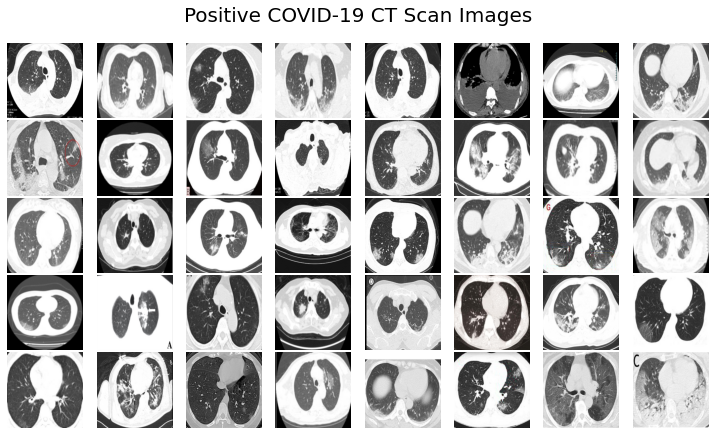

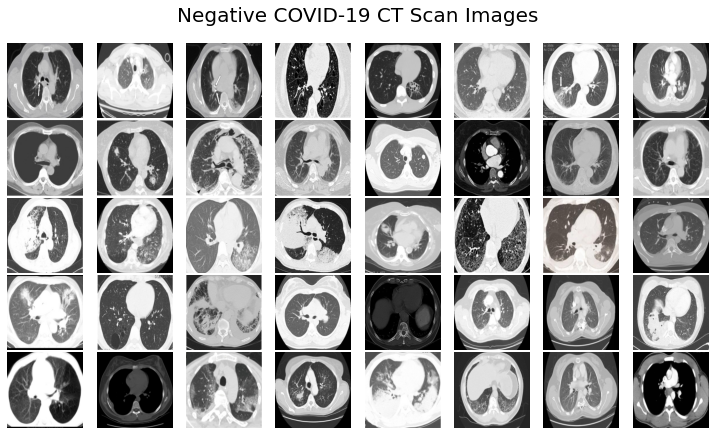

In [12]:
# Plotting the Positive COVID and Negative COVID datasets

plot_images_from_datasets(covid_images, 'Positive COVID-19 CT Scan Images')
plot_images_from_datasets(noncovid_images, 'Negative COVID-19 CT Scan Images')

# Convert to array and Normalize to interval
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

# Split the dataset into train,test and concatenate the datasets

In [13]:
# Split into training and testing sets 

# COVID Positive 
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)

#COVID Negative
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

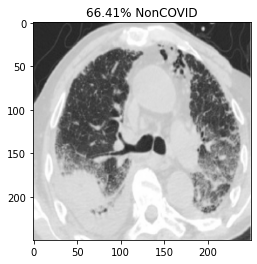

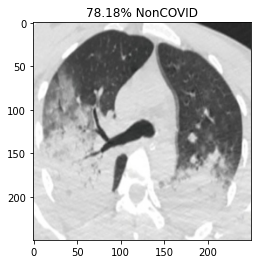

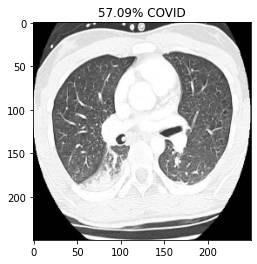

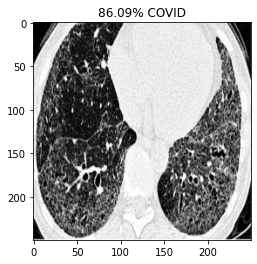

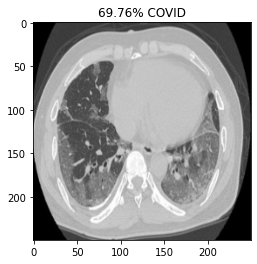

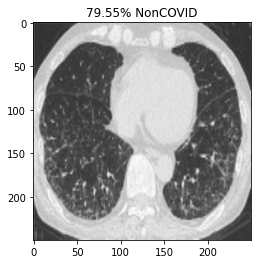

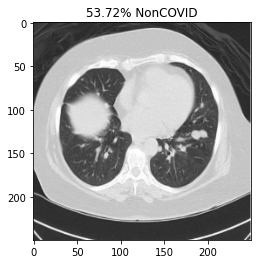

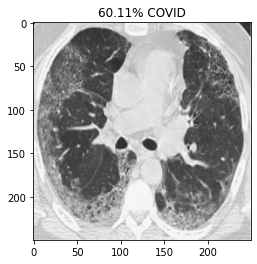

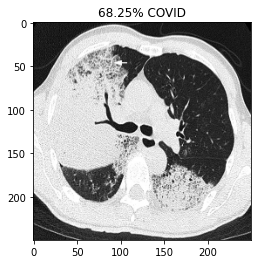

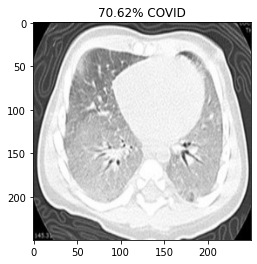

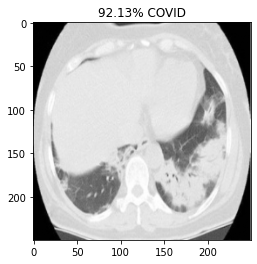

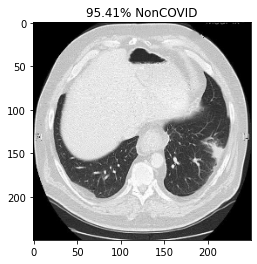

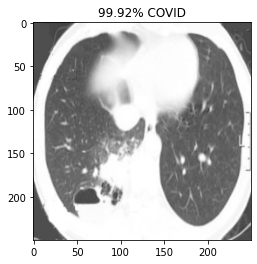

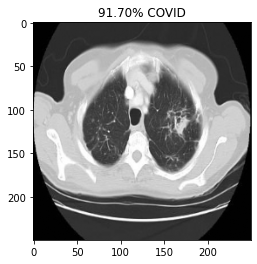

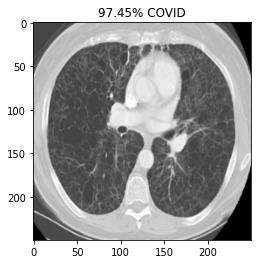

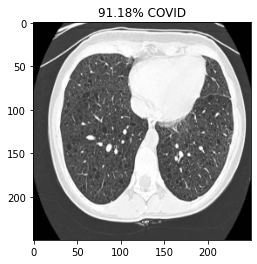

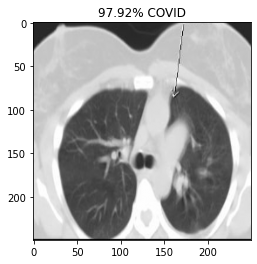

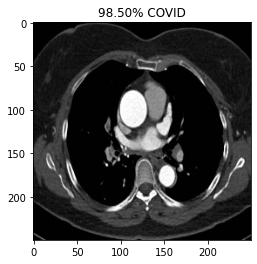

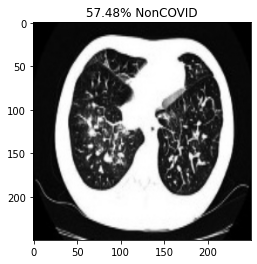

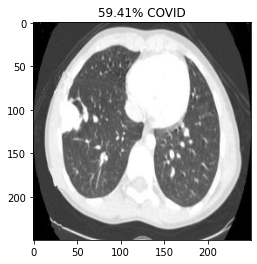

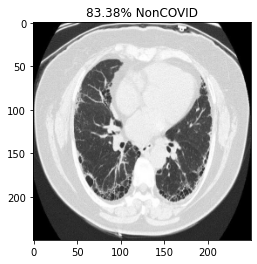

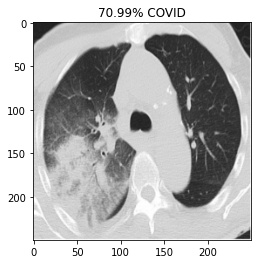

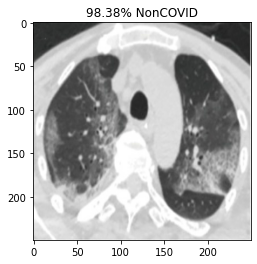

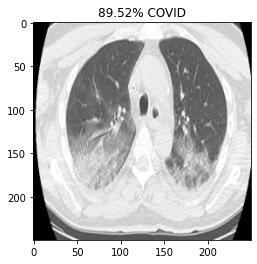

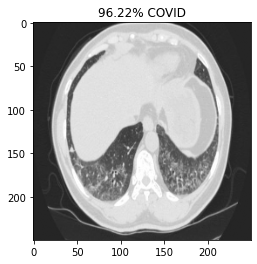

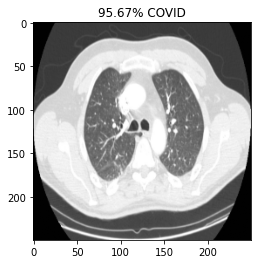

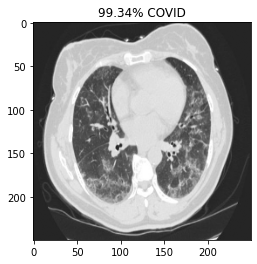

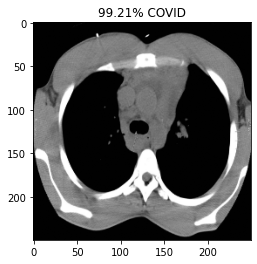

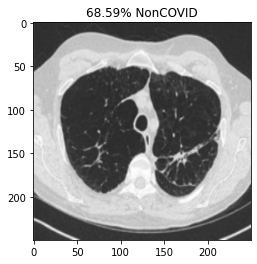

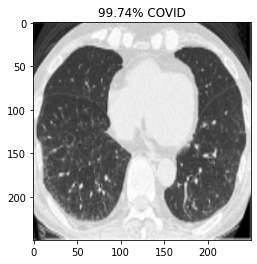

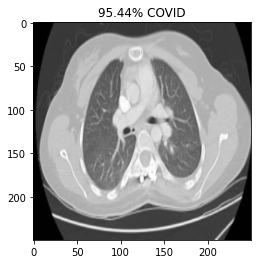

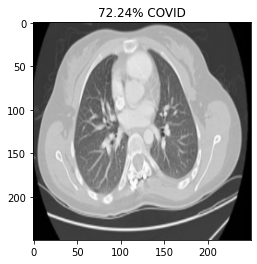

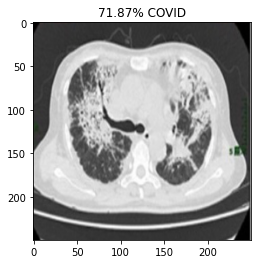

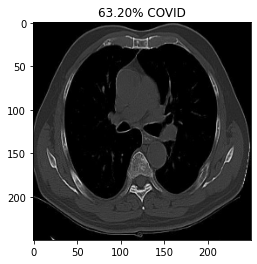

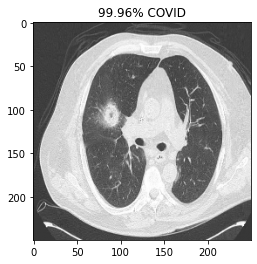

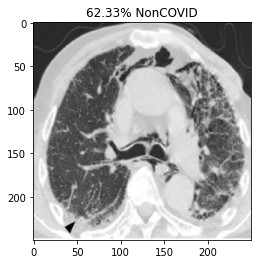

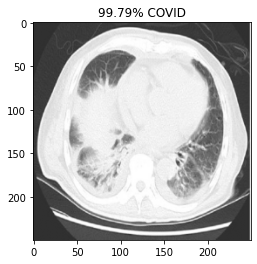

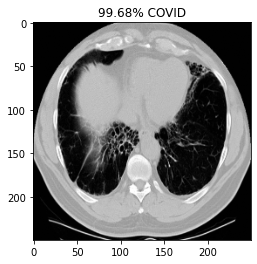

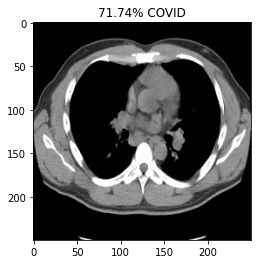

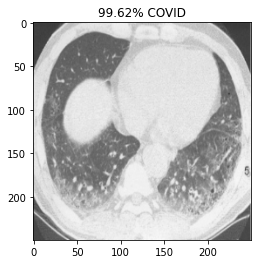

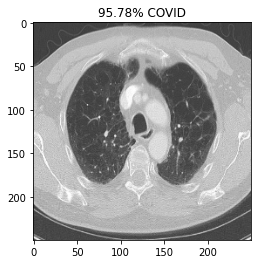

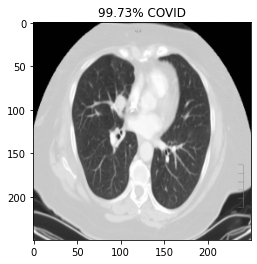

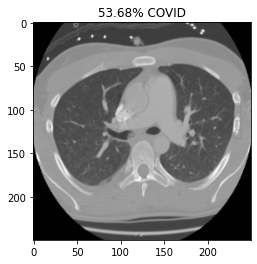

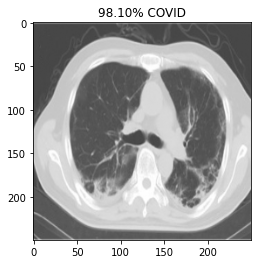

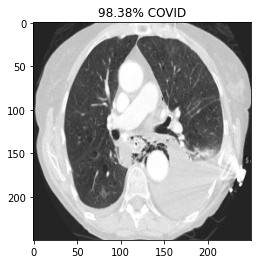

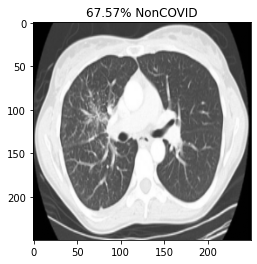

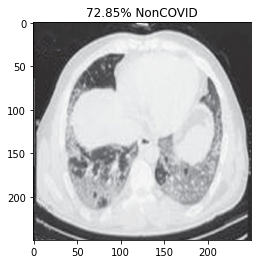

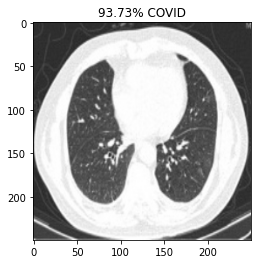

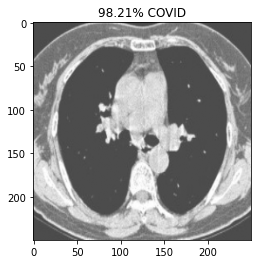

In [17]:
# Load saved model
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

model = load_model('/content/drive/MyDrive/Temp/vgg_ct_trail_50_epoch_karan_patel.h5')
y_pred = model.predict(X_test, batch_size=batch_size)

#Let's Look the 1 to 50 images#

prediction=y_pred[1:50]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

# Let's Try algorithm on random image of CT scan. (POSITIVE COVID19)

Patient detail
*  COVID-19 pneumonia - lung window
* Age: 75 years
* Gender: male    
    
normal image ref: https://radiopaedia.org/cases/covid-19-pneumonia-12?lang=gb 

[[0.04444299 0.95555705]]


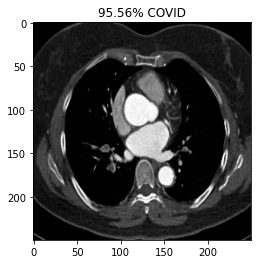

In [ ]:
# First try on random positive image Let's see how algorithm works.

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import sys
from PIL import Image

successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img  = cv2.imread('Sample_image_1_COVID_Postive.jpeg')
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # arrange format as per deep learning libraries
img  = cv2.resize(img,(250,250))                 # resize as per model

x = img_to_array(img)  # Numpy array with shape (250, 250, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 250, 250, 3)

# Rescale by 1/255 
x /= 255

# Make prediction
successive_feature_maps = model.predict(x)
print(successive_feature_maps)

for index, probability in enumerate(successive_feature_maps):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

# Let's Try algorithm on random image of CT scan. (Negative COVID19)
 Image is negative let's see how algorithms works on that.

Patient detail

* Negative HRCT for COVID19 - lung window
* Patient have HRCT of lung showing extensive fibrosis possibly from usual interstitial pneumonitis. There is also a large   emphysematous bullae.

normal image ref: https://en.wikipedia.org/wiki/High-resolution_computed_tomography#/media/File:Pulmon_fibrosis.PNG

[[0.71763283 0.28236714]]


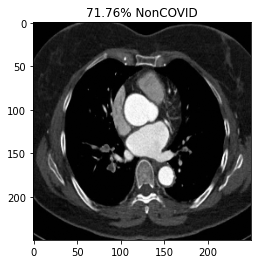

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import sys
from PIL import Image

successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img  = cv2.imread('Sample_image_1_COVID_Negative(Normal).png')
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # arrange format as per deep learning libraries
img  = cv2.resize(img,(250,250))                 # resize as per model

x = img_to_array(img)  # Numpy array with shape (250, 250, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 250, 250, 3)

# Rescale by 1/255 
x /= 255

# Make prediction
successive_feature_maps = model.predict(x)
print(successive_feature_maps)

for index, probability in enumerate(successive_feature_maps):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()